## Data

We will use data from USA only

We use the 153 characteristics used by JKP

We will use Kenneth French's industry portfolios

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets
from datetime import datetime
import matplotlib.pyplot as plt
from utils_new import demarket, regcov, l2est
from cross_validate import cross_validate
import yfinance as yf




data = pd.read_csv("C:/Users/ulrik/Downloads/[usa]_[all_factors]_[monthly]_[vw_cap].csv")

#Get unique values
unique_values = data.iloc[:, 1].unique() 

data["date"] = pd.to_datetime(data["date"])
data = data[data["date"] >= "1980-01-01"]
data["date"] = data["date"].dt.strftime("%Y-%m")

data
ff_dict = FamaFrenchReader('10_Industry_Portfolios',
                           start='1980-01-01', 
                           end='2023-12-31').read()

ff_dict_returns = ff_dict[1] / 100
data_short = data[['name', 'date', 'ret']]

df = pd.DataFrame(data)


df['date'] = pd.to_datetime(df['date'])

df_wide = df.pivot(index='date', columns='name', values='ret')


SPX = data = pd.read_csv("C:/Users/ulrik/Downloads/S&P 500 Historical Data.csv")

SPX['Date'] = pd.to_datetime(SPX['Date'], format='%m/%d/%Y')  # Adjust format if needed

# Set 'Date' as index and keep only 'Change %' column
SPX = SPX.set_index('Date')[['Change %']]
SPX = SPX.iloc[::-1]

SPX['Change %'] = SPX['Change %'].str.rstrip('%').astype(float) / 100

from fredapi import Fred
import pandas_datareader.data as web



# Define the time range
start_date = "1980-01-01"
end_date = "2023-12-01"

# Fetch 1-month Treasury bill rate from FRED
t_bill_monthly = web.DataReader('DGS1', 'fred', start_date, end_date)

# Resample to monthly frequency (if needed)
t_bill_monthly = t_bill_monthly.resample('M').last()


t_bill_monthly = (1 + t_bill_monthly / 100) ** (1 / 12) - 1

# Ensure the index is in datetime format
t_bill_monthly.index = pd.to_datetime(t_bill_monthly.index)

# Convert end-of-month dates to start-of-month
t_bill_monthly.index = t_bill_monthly.index.to_period("M").to_timestamp(how="start")

merged_df = pd.concat([SPX, t_bill_monthly], axis=1)
merged_df['mkt_er'] = merged_df['Change %'] - merged_df['DGS1']

mkt_er = merged_df[['mkt_er']]
mkt_er_1 = mkt_er['mkt_er']
SPX_1 = SPX.squeeze()


# Visuals

In [2]:
def plot_dof(df, x, p):
    """
    degrees of freedom <-> kappa plot
    
    Parameters:
    - df: Degrees of freedom data to be plotted on the y-axis.
    - x: Data to be plotted on the x-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot
    plt.plot(x, df, linewidth=p['line_width'])
    
    # Log-scale adjustments
    if p['L1_log_scale']:
        plt.yscale('log')
        plt.yticks([tick + 1e-12 for tick in plt.yticks()[0]])  # Adding a small constant
    
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-12 for tick in plt.xticks()[0]])  # Adding a small constant
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel('Effective degrees of freedom', fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Setting x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/degrees_of_freedom.png', dpi=300, bbox_inches='tight')


def plot_L2coefpaths(x, phi, iL2opt, anomalies, ylbl, p):
    """
    L2 coefficients paths plot
    
    Parameters:
    - x: Data for the x-axis.
    - phi: Coefficient path data.
    - iL2opt: Optimal index for regularization.
    - anomalies: Names for legends.
    - ylbl: Label for the y-axis.
    - p: Dictionary containing various plot parameters.
    """
    
    # Decide sorting location
    if p['L2_sort_loc'] == 'opt':
        iSortLoc = iL2opt
    elif p['L2_sort_loc'] == 'OLS':
        iSortLoc = 0
    else:
        raise ValueError('Unknown option')
    
    # Sorting mechanism
    if p['n'] > p['L2_max_legends']:
        I = np.argsort(-np.abs(phi[:, iSortLoc]))  # Descending sort by absolute value
    else:
        I = np.argsort(-phi[:, iSortLoc])  # Descending sort
    
    # Open a new figure
    plt.figure()
    
    # Plot
    for i in I:
        plt.plot(x, phi[i, :], linewidth=p['line_width'])
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels and grid
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(ylbl, fontsize=12, labelpad=10, fontweight='bold')
    plt.grid(True)
    
    # Legend
    idx = I[:min(p['L2_max_legends'], len(I))]
    plt.legend([anomalies[i] for i in idx], loc=p['legend_loc'], fontsize=p['font_size'], bbox_to_anchor=(1.05, 1))
    
    # Dashed line at optimal regularization
    plt.plot([x[iL2opt], x[iL2opt]], [np.min(phi), np.max(phi)], '--k')
    
    # x-axis limits
    plt.xlim([min(x), max(x)])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        if ylbl == 'SDF Coefficient, $b$':
            plt.savefig('results_export/coefficients_paths.png', dpi=300, bbox_inches='tight')
        elif ylbl == 'SDF Coefficient $t$-statistic':
            plt.savefig('results_export/tstats_paths.png', dpi=300, bbox_inches='tight')


def plot_L2cv(x, objL2, p):
    """
    Plot SSE/objective & BIC as a function of degrees of freedom.
    
    Parameters:
    - x: Data for the x-axis.
    - objL2: Data for plotting objectives and possible other values.
    - p: Dictionary containing various plot parameters.
    """
    
    # Open a new figure
    plt.figure()
    
    # Plot In-sample (IS) and Out-of-Sample (OOS)
    plt.plot(x, objL2[:, 0], '--', linewidth=p['line_width'])  # IS
    plt.plot(x, objL2[:, 1], '-', linewidth=p['line_width'])  # OOS
    
    # Log-scale adjustment
    if p['L2_log_scale']:
        plt.xscale('log')
        plt.xticks([tick + 1e-16 for tick in plt.xticks()[0]])
    
    # Labels
    plt.xlabel(p['xlbl'], fontsize=12, labelpad=10, fontweight='bold')
    plt.ylabel(f"IS/OOS {p['sObjective']}", fontsize=12, labelpad=10, fontweight='bold')
    
    # Legends and plot +1, -1 standard error
    co = plt.gca().lines[-1].get_color()  # Getting color of last line plotted (OOS line)
    plt.plot(x, objL2[:, 1] + objL2[:, 3], ':', color=co, linewidth=1)  # +1 SE
    plt.plot(x, objL2[:, 1] - objL2[:, 3], ':', color=co, linewidth=1)  # -1 SE
    
    plt.legend(['In-sample', f"OOS {p['method']}", f"OOS {p['method']} +/- 1 s.e."],
               loc='upper right')
    
    # Grid, axis limits
    plt.grid(True)
    plt.ylim([0, max(0.1, min(10, 2*max(objL2[:, 1])))])
    plt.xlim([min(x), 2])
    
    # Show plot
    if p['show_plot']:
        plt.show()

    if p['results_export']:
        plt.savefig('results_export/cross_validation.png', dpi=300, bbox_inches='tight')



def table_L2coefs(phi, se, anomalies, p):
    """
    Function to display a table of largest coefficients and t-stats.

    Parameters:
    - phi: Coefficients.
    - se: Standard error.
    - anomalies: Anomaly descriptions.
    - p: Dictionary containing various parameters.
    """
    nrows = 10  # number of rows in the table to show
    
    # t-stats
    tstats = phi / se
    
    # by absolute tstats
    idx = np.argsort(np.abs(tstats))[::-1]
    
    # show only nrows items
    idx = idx[:nrows]
   
    # create a DataFrame
    data = {
        'Portfolio': [anomalies[i] for i in idx],
        'b': phi[idx],
        't_stat': np.abs(tstats[idx])
    }
    df = pd.DataFrame(data)
    
    # display table
    print(df)

    # export as a latex formatted table
    if p['results_export']:
        df.to_latex('results_export/coefficients_table.tex', index=False)

# Fixes index

In [3]:
ff_dict_returns.index = df_wide.index

In [4]:
# Generate monthly dates as a Pandas Series
date_series = pd.Series(pd.date_range(start="1980-01-01", end="2023-12-01", freq='MS'))

# Accessing both .iloc and .strftime()
print(date_series.iloc[-1])  # Extract the last date (2023-12-01)
print(date_series.iloc[-1].strftime('%Y-%m-%d'))  # Format the last date as a string

2023-12-01 00:00:00
2023-12-01


# Define function

In [ ]:

def SCS_L2est(dates, re, market, freq, anomalies, parameters):
    """
    Computes the L2 shrinkage estimator of the SDF parameters
    based on the method in Kozak, Nagel, and Santosh (2019).
    
    Parameters:
    - dates (pd.Series): time series of dates
    - re (pd.DataFrame): matrix of excess returns time series
    - market (pd.Series): matrix of market's excess returns time series
    - freq (int): number of observations per year
    - anomalies (list): list of anomaly names
    - kwargs: other optional keyword arguments
        * gridsize (int): default=20
        * cvmethod (str): default='CV'
        * kfold (int): default=4
        * objective (str): default='C-S R^2'
        * plot_dof (bool): default=False
        * plot_coefpaths (bool): default=False
        * plot_objective (bool): default=False
        * ... more parameters...
    
    Returns:
    - estimates (dict): structure of estimates
    
    Note: Always cite the paper when using this function.
    """

    # Assign default values
    parameters = {
        'gridsize': 100,
        'method': 'CV',
        'objective': 'CSR2',
        'ignore_scale': False,
        'kfold': 3,
        'oos_test_date': dates.iloc[-1],
        'freq': freq,
        'rotate_PC': False,
        'demarket_conditionally': False,
        'demarket_unconditionally': True,
        'devol_conditionally': False,
        'devol_unconditionally': True,
        'plot_dof': True,
        'plot_coefpaths': True,
        'plot_objective': True,
        'line_width': 1.5,
        'font_size': 10,
        'L2_max_legends': 20,
        'L2_sort_loc': 'opt',
        'L1_log_scale': True,
        'L2_log_scale': True,
        'legend_loc': 'best',
        'results_export': True,
        'show_plot': False
    }

    # Parse config and assign default values
    # parameters = parse_config(parameters, default_config)

    # We usually maximize an objective (e.g., R^2), except for HJ-distance (GLS) and SSE
    if parameters["objective"] in ['GLS', 'SSE']:
        optfunc = min
    else:
        optfunc = max

    # User-friendly names for objectives to use in plots
    mapObj = {
        'CSR2': 'Cross-sectional $R^2$',
        'GLSR2': 'Cross-sectional GLS $R^2$',
        'GLS': 'Residual $SR^2$',
        'SRexpl': 'Explained SR',
        'SSE': 'SDF RMSE',
        'SR': 'Sharpe Ratio',
        'MVU': 'Mean-variance utility'
    }
    parameters["sObjective"] = mapObj[parameters["objective"]]

    # Initialize; compute means, cov, SVD decomposition
    # Testing sample start date
    tT0 = parameters["oos_test_date"]
    re.index = dates.values
    market.index = dates.values

    mkt0 = market.copy()

    # De-market all excess returns 
    if parameters['demarket_conditionally']:  # conditionally
        demarket_ma_window = 10 * parameters['freq']  # use past 3 years to estimate betas

        # Placeholder for custom function `demarkcond`
        r0 = demarketcond(re.iloc[idx_train, :], market.iloc[idx_train], demarket_ma_window)
        idx_train = idx_train[demarket_ma_window:]  # drop NaNs

    elif parameters['demarket_unconditionally']:  # unconditionally

        # Placeholder for custom function `demarket`
        r_train, b_train = demarket(re.loc[:tT0, :], market.loc[:tT0])
        r_test = demarket(re.loc[tT0:, :], market.loc[tT0:], b_train)  # use betas estimated in the training sample
        # check if r_test is a dataframe
        if isinstance(r_test, pd.DataFrame):
            r0 = pd.concat([r_train, r_test], axis=0)
        else:
            r0 = r_train.copy()

    else:
        r0 = re.copy()

    # De-vol all excess returns conditionally if requested
    if parameters['devol_conditionally']:
        devol_ma_window = 22  # use past 22 days to estimate volatilities

        # Placeholder for custom function `devolcond`
        r0, mkt0 = devolcond(r0, market, devol_ma_window)
        idx_train = idx_train[devol_ma_window:]  # drop NaNs

    elif parameters['devol_unconditionally']:  # de-vol unconditionally

        # Normalize so that all returns have the standard deviation of the VW market
        r0 = r0.divide(r0.std(axis=0), axis=1).multiply(market.std())

    # Construct dates, mkt, and returns for train and test sets
    mkt = mkt0.loc[:tT0]
    mkt_test = mkt0.loc[tT0:]

    r_train = r0.loc[:tT0, :]
    r_test = r0.loc[tT0:, :]

    # Length of the training sample
    T, n = r_train.shape
    parameters['T'] = T
    parameters['n'] = n

    # Rotate into PC space if requested and change file suffix
    if parameters.get('rotate_PC', False):
        # Use training sample to form eigenvectors
        _, _, Q = np.linalg.svd(np.cov(r_train, rowvar=False)) 
        r_train = np.dot(r_train, Q)
        r_test = np.dot(r_test, Q)
        anomalies = ['PC' + str(i) for i in range(1, n + 1)]

    # Compute first and second moments
    X = regcov(r_train)
    y = np.mean(r_train, axis=0)#.reshape(-1, 1)  # making y a column vector
    #X_test = regcov(r_test)  # TODO: test does not have data in it!!
    #y_test = np.mean(r_test, axis=0)#.reshape(-1, 1)  # making y_test a column vector

    # Maximum in-sample SR
    w = np.dot(np.dot(y.T, np.linalg.pinv(X)), y)
    maxSR2 = freq * w

    # Precompute E-V decomposition
    U, D, Q = np.linalg.svd(X)
    X2 = np.dot(np.dot(Q, np.sqrt(np.diag(D))), Q.T)
    d = np.sum(np.diag(D), axis=1)

    # Pre-compute pseudo inverses
    tol = max(X.shape) * np.finfo(float).eps * np.linalg.norm(d, np.inf)
    r1 = np.sum(d > tol) + 1
    Q1 = Q[:, :r1]
    s = d[:r1]
    s2 = 1 / np.sqrt(s)
    s = 1 / s
    Q1 = Q1.T
    Xinv = np.dot(Q1 * s.reshape(1, -1), Q1.T)
    X2inv = np.dot(Q1 * s2.reshape(1, -1), Q1.T)

    # Options
    parameters['xlbl'] = 'Root Expected SR$^2$ (prior), $\\kappa$'
    parameters['Q'] = Q
    parameters['d'] = d
    parameters['Xinv'] = Xinv


    # Functions to map L2pen <-> kappa
    kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)

    # Find left and right limits
    lr = np.arange(1, 22)  # equivalent of 1:21 in MATLAB
    lm = 1

    z = np.empty((n, len(lr)))
    z.fill(np.nan)

    for i in lr:
        params = parameters.copy()  # Make a copy of p to avoid modifying the original
        params['L2pen'] = kappa2pen(2 ** (i - lm), T, X, parameters)
        z[:, i - 1] = l2est(X, y, params)[0]

    # Coefficient stabilize condition
    mean_val = np.mean(np.abs((z[:, 1:] - z[:, :-1])) / (1 + np.abs(z[:, :-1])), axis=0) > 0.01
    x_rlim = np.nonzero(mean_val)[0]

    # Use the left and right points to define the support and create a finer grid on this support
    x = np.logspace(np.log10(2**x_rlim[-1]), np.log10(0.01), parameters['gridsize'])
    l = [kappa2pen(val, T, X, parameters) for val in x]
    lCV = [val / (1 - 1 / parameters['kfold']) for val in l]  
    nl = len(l)

    # Estimate the L2 model
    params = parameters.copy() # Make a copy of p to avoid modifying the original

    # Create placeholders for outputs
    phi = np.full((n, nl), np.nan)
    se = np.full_like(phi, np.nan)
    objL2 = np.full((nl, 4), np.nan)
    objL2_folds = np.full((nl, params['kfold']), np.nan)  # Assuming params['kfold'] is the number of folds
    MVE = [None] * nl

    for i in range(nl):
        print(i)
        # Estimate parameters at each grid point
        params['L2pen'] = l[i]
        # Note: You need to define the l2est function in Python or provide its MATLAB code for translation
        phi[:, i], _, se[:, i] = l2est(X, y, params, True)

        # Cross validate estimated parameters
        params['L2pen'] = lCV[i]
        # Note: You need to define the cross_validate function in Python or provide its MATLAB code for translation
        objL2[i, :], params, objL2_folds_ = cross_validate(l2est, dates.values, r_train, params)
        objL2_folds[i, :] = objL2_folds_[:, 1] # Python is 0-indexed

        # Store OOS MVE portfolios for each CV run
        MVE[i] = params['cv_MVE']

    cv_idx_test = params['cv_idx_test'] 

    # Effective degrees of freedom
    df = np.sum(d.reshape(153,1) / (d.reshape(153,1) + np.array(l).reshape(1,100)), axis=0)

    # Optimal L2 model
    
    objL2opt = optfunc(objL2[:, 1])
    if optfunc == max:
        iL2opt = objL2[:, 1].argmax()
    if optfunc == min:
        iL2opt = objL2[:, 1].argmin()
    bL2 = phi[:, iL2opt]
    parameters['bL2'] = bL2
    parameters['R2oos'] = objL2opt
    L2optKappa = x[iL2opt]

    # MVE portfolios for each fold at the optimal level of shrinkage [flatten into single time-series]
    MVEopt = MVE[iL2opt]

    # Return coefficients paths, degrees of freedom, and objective's value
    parameters['coeffsPaths'] = phi
    parameters['objL2_IS'] = objL2[:, 0]
    parameters['objL2_OOS'] = objL2[:, 1]
    z = np.concatenate([MVEopt[key] for key in MVEopt], axis=0)
    parameters['optimal_model_L2'] = {
        'coefficients': bL2,
        'objective': objL2opt,
        'kappa': L2optKappa,
        'SR': np.mean(z) / np.std(z) * np.sqrt(parameters['freq'])
    }
    estimates = parameters

    # df <-> kappa plot
    if parameters['plot_dof']:  # plot degrees of freedom
        plot_dof(df, x, parameters)

    # SDF 2nd moment constraint (L2) coefficients 
    if parameters['plot_coefpaths']:
        # plot coefficients
        plot_L2coefpaths(x, phi, iL2opt, anomalies, 'SDF Coefficient, $b$', parameters)
        # plot t-stats
        plot_L2coefpaths(x, phi/se, iL2opt, anomalies, 'SDF Coefficient $t$-statistic', parameters)

    # L2 Cross-Validation/BIC plot
    if parameters['plot_objective']:
        plot_L2cv(x, objL2, parameters)

    # output table with coefficient & tstats estimates
    table_L2coefs(phi[:, iL2opt], se[:, iL2opt], anomalies, parameters)

    return estimates


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


C:\Users\ulrik\AppData\Local\Temp\ipykernel_936\1081739709.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  kappa2pen = lambda kappa, T, X, p: p['freq'] * np.trace(X) / T / (kappa ** 2)
c:\Users\ulrik\Desktop\utils_new.py:64: RuntimeWarning: invalid value encountered in multiply
  b = np.linalg.solve(X + l * np.eye(X.shape[0]), y)


19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
      Portfolio         b    t_stat
0        cop_at  0.321287  1.490061
1     cowc_gr1a  0.280290  1.301305
2        noa_at  0.277141  1.286428
3      cop_atl1  0.256986  1.188766
4  oaccruals_at  0.251625  1.165053
5     nfna_gr1a  0.240336  1.116400
6      fnl_gr1a  0.226283  1.051029
7      noa_gr1a  0.224321  1.034623
8   seas_6_10an  0.210796  0.980296
9     ncoa_gr1a  0.202239  0.934531


C:\Users\ulrik\AppData\Local\Temp\ipykernel_936\1694627815.py:189: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('results_export/coefficients_table.tex', index=False)


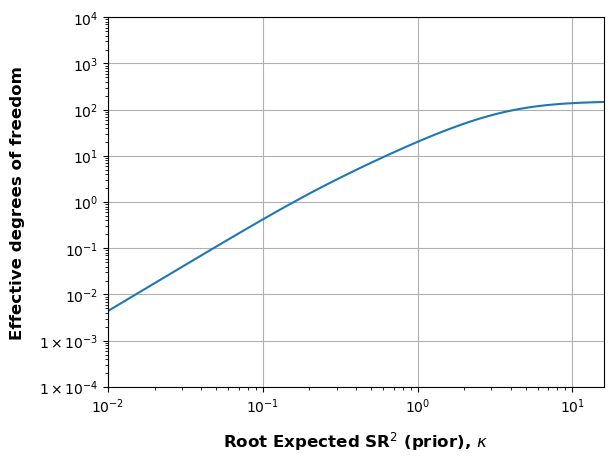

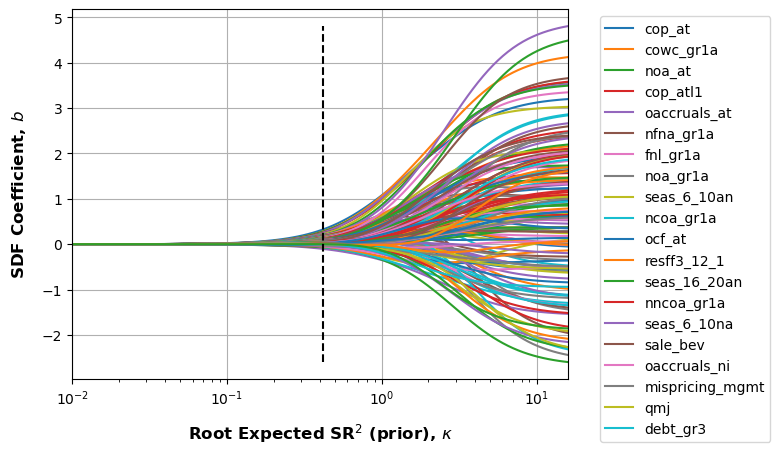

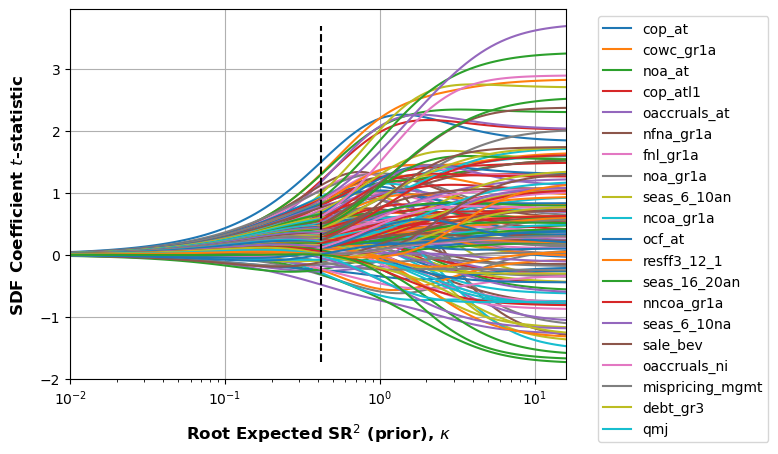

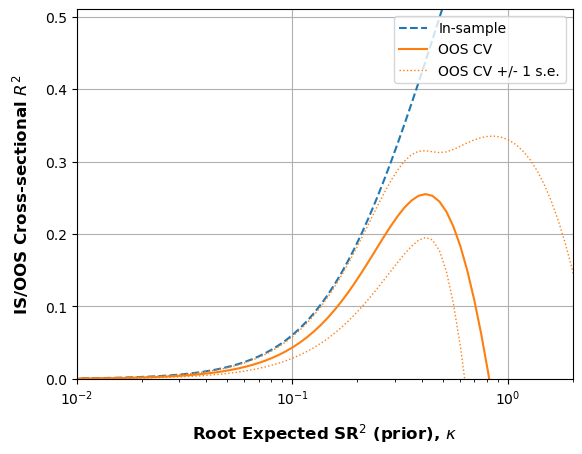

In [6]:
test = SCS_L2est(date_series,df_wide,SPX_1,12, unique_values, {})

# Dual-Penalty test

In [7]:
import numpy as np
import pandas as pd

def elastic_net_sdf_cd(df_factors, gamma1, gamma2, max_iter=1000, tol=1e-6):
    """
    Solve the dual-penalty SDF estimation problem via coordinate descent:
         min_b (mu - Sigma b)^T Sigma^{-1} (mu - Sigma b)
               + gamma2 * ||b||^2
               + gamma1 * ||b||_1

    Accepts a DataFrame of factor returns and retains the column labels,
    but uses the numeric .values for computations.
    """
    # 1. Store column names for reference
    factor_names = df_factors.columns

    # 2. Convert to NumPy array
    F = df_factors.values
    T, H = F.shape

    # 3. Compute sample mean and covariance
    mu_hat = F.mean(axis=0)
    Sigma_hat = regcov(F)

    # 4. Invert or pseudo-invert Sigma
    try:
        Sigma_inv = np.linalg.inv(Sigma_hat)
    except np.linalg.LinAlgError:
        Sigma_inv = np.linalg.pinv(Sigma_hat)

    # 5. Initialize coefficient vector
    b = np.zeros(H)

    for _iter in range(max_iter):
        b_old = b.copy()

        for j in range(H):
            # Gradient from HJ-distance part
            G = Sigma_inv.dot(mu_hat - Sigma_hat.dot(b))
            grad_j_HJ = -2.0 * Sigma_hat[:, j].dot(G)

            # Gradient from L2
            grad_j_L2 = 2.0 * gamma2 * b[j]

            # Total gradient (ignoring L1 subgradient)
            grad_j = grad_j_HJ + grad_j_L2

            # Approximate Hessian for j
            hess_j = 2.0*(Sigma_hat[j, j] * Sigma_inv[j, j]) + 2.0*gamma2

            # Unconstrained update
            b_j_unconstr = b[j] - (1.0 / hess_j) * grad_j

            # Soft-threshold for L1
            thresh = gamma1 / hess_j
            if b_j_unconstr > thresh:
                b[j] = b_j_unconstr - thresh
            elif b_j_unconstr < -thresh:
                b[j] = b_j_unconstr + thresh
            else:
                b[j] = 0.0

        # Convergence check
        if np.linalg.norm(b - b_old) < tol:
            break

    # 6. Return both the numeric coefficients and the factor names
    return pd.Series(b, index=factor_names, name='SDF Coefficients')


In [8]:
test_elastic_2 = elastic_net_sdf_cd(df_wide, 0.01, 0.01)

In [35]:
import numpy as np

# example grids (expand or shrink as needed)
gamma1_range = np.logspace(-4, 2, 10)  # e.g. [0.001, 0.01, 0.1, 1.0, 10.0]
gamma2_range = np.logspace(-4, 2, 10)

def cs_r2_metric(F, b):
    """
    Compute cross-sectional R^2 in the hold-out set:
      R^2 = 1 - [ (mu_test - Sigma_test*b)^T (mu_test - Sigma_test*b ) / mu_test^T mu_test ]
    """
    mu_test = F.mean(axis=0)               # (H,)
    Sigma_test = np.cov(F, rowvar=False)   # (H, H)
    pred_mean = Sigma_test @ b            # shape (H,)

    numerator = np.sum((mu_test - pred_mean)**2)
    denominator = np.sum(mu_test**2)
    return 1.0 - numerator / denominator

def cross_validate_elastic_net(df_wide, gamma1_values, gamma2_values,
                               K=3, max_iter=1000):
    """
    Perform K-fold cross-validation over a grid of (gamma1, gamma2) values
    to find the pair that maximizes cross-sectional R^2 out of sample.

    Parameters
    ----------
    df_wide : pd.DataFrame, shape (T, H)
        Factor returns over time
    gamma1_values : iterable of floats
    gamma2_values : iterable of floats
    K : int
        number of folds
    max_iter : int
        for coordinate descent, if needed

    Returns
    -------
    best_gamma1 : float
    best_gamma2 : float
    best_score : float
        The best average CV R^2
    scores : dict[ (g1, g2) -> float ]
        All cross-validated R^2 for each pair
    """

    T = df_wide.shape[0]
    
    # We shuffle or just split in contiguous folds
    # (Time-series often needs special care, but here's a simple example)
    fold_sizes = np.full(K, T//K, dtype=int)
    fold_sizes[: T%K] += 1
    indices = np.arange(T)
    
    # If you want purely contiguous folds, do something like:
    folds = []
    start = 0
    for size in fold_sizes:
        stop = start + size
        folds.append(indices[start:stop])
        start = stop

    scores = {}
    best_score = -np.inf
    best_gamma1 = None
    best_gamma2 = None

    # Double loop over gamma1, gamma2
    for g1 in gamma1_values:
        for g2 in gamma2_values:

            r2_list = []

            # K-fold
            for k in range(K):
                test_idx = folds[k]
                train_idx = np.hstack([folds[i] for i in range(K) if i!=k])

                df_train = df_wide.iloc[train_idx, :]
                df_test  = df_wide.iloc[test_idx, :]

                # Fit model on train subset
                b_series = elastic_net_sdf_cd(df_train, g1, g2, max_iter=max_iter)

                # Evaluate on test subset
                # remember b_series is a pd.Series with same columns as df_train
                # we want a numeric array to pass to cs_r2_metric
                b_num = b_series.values
                F_test = df_test.values  # shape (test_size, H)

                r2_fold = cs_r2_metric(F_test, b_num)
                r2_list.append(r2_fold)

            
            mean_r2 = np.mean(r2_list)
            scores[(g1, g2)] = mean_r2

            # if better than best, update
            if mean_r2 > best_score:
                best_score  = mean_r2
                best_gamma1 = g1
                best_gamma2 = g2

    return best_gamma1, best_gamma2, best_score, scores


best_g1, best_g2, best_r2, cv_scores = cross_validate_elastic_net(
    df_wide, gamma1_range, gamma2_range, K=3
)

print(f"Best average CV R^2 = {best_r2:.4f} at gamma1={best_g1}, gamma2={best_g2}")

# Then, refit the entire dataset at that best penalty:
b_opt = elastic_net_sdf_cd(df_wide, best_g1, best_g2)
print("Optimal SDF Coefficients:")
print(b_opt)


Best average CV R^2 = 0.2051 at gamma1=0.002154434690031882, gamma2=0.046415888336127774
Optimal SDF Coefficients:
name
age                 -0.002699
aliq_at              0.000000
aliq_mat            -0.017336
ami_126d             0.000000
at_be                0.000000
                       ...   
turnover_var_126d    0.000000
z_score              0.000000
zero_trades_126d     0.000000
zero_trades_21d     -0.015125
zero_trades_252d     0.000000
Name: SDF Coefficients, Length: 153, dtype: float64


In [64]:
df_wide_train = df_wide.iloc[:369, :]
df_wide_test = df_wide.iloc[370:, :]

In [67]:
# Define your gamma ranges using np.logspace
gamma1_range = np.logspace(-4, 2, 10)  # e.g., [0.1, 1, 10, 100, 1000]
gamma2_range = np.logspace(-4, 2, 10)  # same as above

# List to hold results for each gamma1, gamma2 pair
results = []

# Loop over each gamma1 and gamma2 combination
for gamma1 in gamma1_range:
    for gamma2 in gamma2_range:
        # Estimate the SDF coefficients for the given pair of gammas
        coef_series = elastic_net_sdf_cd(df_wide_train, gamma1, gamma2)
        
        # Create a dictionary for the current pair:
        # Start with gamma values
        result_dict = {'gamma1': gamma1, 'gamma2': gamma2}
        # Add all the coefficient estimates (the series keys are the factor names)
        result_dict.update(coef_series.to_dict())
        
        # Append the dictionary to our results list
        results.append(result_dict)

# Convert the list of dictionaries into a DataFrame
L1L2_coef = pd.DataFrame(results)



In [68]:
L1L2_coef_no_gamma = L1L2_coef.iloc[:, 2:]

# Initialize a list to collect R^2 values
r2_list = []

# Iterate over each row of L1L2_coef_no_gamma
for idx, row in L1L2_coef_no_gamma.iterrows():
    # Convert the row to a numpy array (this is our beta coefficient vector)
    b = row.values
    # Compute the R^2 for this set of coefficients using the hold-out set F_holdout
    r2 = cs_r2_metric(df_wide_test, b)
    r2_list.append(r2)

# Create a DataFrame to store the results, preserving the index of L1L2_coef_no_gamma
R_2_oos_values = pd.DataFrame({'R2': r2_list}, index=L1L2_coef_no_gamma.index)

# Display the new DataFrame
print(R_2_oos_values)


          R2
0   0.444358
1   0.456463
2   0.472237
3   0.431413
4   0.298205
..       ...
95  0.000000
96  0.000000
97  0.000000
98  0.000000
99  0.000000

[100 rows x 1 columns]


In [80]:
sigma_kappa = regcov(df_wide_train)
mu_kappa = np.mean(df_wide_train, axis=0)

def kappa(mu,Sigma):
    # Compute the inverse of Sigma
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Compute kappa
    kappa = np.sqrt(mu.T @ Sigma_inv @ mu)
    
    return float(kappa)

test_kappa = kappa(mu_kappa,sigma_kappa)

In [103]:
L1L2_coef_no_gamma_mean = np.mean(L1L2_coef_no_gamma, axis=0)

def compute_sample_covariance(F, mu_bar):
    """
    Computes the sample covariance matrix using the formula:
    Σ̄ = (1/T) * sum((F_t - μ̄) @ (F_t - μ̄)')

    Parameters:
    - F: (T, H) numpy array where T is the number of time periods, H is the number of factors.

    Returns:
    - Sigma_bar: (H, H) numpy array (sample covariance matrix)
    """
    T, H = F.shape  # Number of time periods and factors
    
    # Compute mean vector (H, )
    mu_bar = mu_bar  # (1, H) row vector
    
    # Compute deviations (F_t - mū) for each t
    deviations = F - mu_bar  # (T, H)
    
    # Compute the covariance matrix using the given formula
    Sigma_bar = (1 / T) * (deviations.T @ deviations)  # (H, H) matrix
    
    return Sigma_bar

cov_test = compute_sample_covariance(L1L2_coef_no_gamma, L1L2_coef_no_gamma_mean)


In [106]:


print(L1L2_coef_no_gamma_mean.shape)

(153,)


In [105]:
cov_test.shape

(153, 153)